In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../src')
import spaceoracle
from spaceoracle.models.probabilistic_estimators import ProbabilisticPixelModulators
import pandas as pd
from spaceoracle.callbacks.fixtures.simulator import SimulatedData

In [16]:
from spaceoracle.models.estimators import SimpleCNN
from spaceoracle.models.vit_blocks import ViT
from spaceoracle.models.spatial_map import xyc2spatial

In [4]:
SimulatedData.gt

,id,row,col,latitude,longitude,beta0,beta1,beta2,x1,x2,y,proj_x,proj_y
0,0,0,0,37.5,115.000000,1.058540,2.293887,1.056346,0.391720,0.566888,2.555933,12801741.44,4483017.170
1,1,0,1,37.5,115.015873,1.015311,1.972091,1.112009,0.479254,0.183225,2.164192,12803508.42,4483017.170
2,2,0,2,37.5,115.031746,1.165811,2.052675,0.740746,0.089783,0.308117,1.578343,12805275.39,4483017.170
3,3,0,3,37.5,115.047619,1.407816,1.831076,1.029166,0.255784,0.107331,1.986638,12807042.37,4483017.170
4,4,0,4,37.5,115.063492,1.348086,2.162551,1.043442,0.887085,0.555066,3.845633,12808809.35,4483017.170
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,63,59,36.5,115.936508,1.559996,2.286203,1.300961,0.542107,0.723439,3.740529,12905993.03,4344222.882
4092,4092,63,60,36.5,115.952381,1.492840,1.992985,1.210815,0.480357,0.827767,3.452458,12907760.00,4344222.882
4093,4093,63,61,36.5,115.968254,1.351371,2.208942,1.013919,0.808941,0.177852,3.318602,12909526.98,4344222.882
4094,4094,63,62,36.5,115.984127,1.481544,2.258388,1.226454,0.213466,0.334173,2.373481,12911293.96,4344222.882


In [11]:
SimulatedData.beta1*SimulatedData.X[:, 0] + SimulatedData.beta2*SimulatedData.X[:, 1] + SimulatedData.beta0

array([2.55593263, 2.16419152, 1.57834272, ..., 3.31860171, 2.3734813 ,
       1.83191203])

In [31]:
spatial_maps = xyc2spatial(
    SimulatedData.xy[:, 0], 
    SimulatedData.xy[:, 1], 
    c=np.zeros(len(SimulatedData.X[:, 0])), 
    m=64, 
    n=64, 
    split_channels=False
)

In [40]:
import seaborn as sns

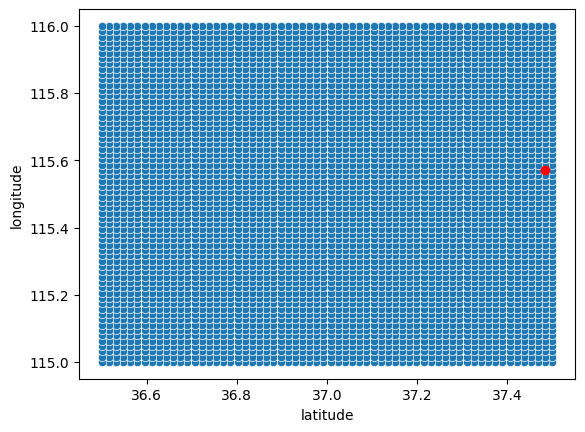

In [44]:
sns.scatterplot(SimulatedData.gt, x='latitude', y='longitude')
plt.scatter(SimulatedData.xy[100][0], SimulatedData.xy[100][1], c='red')
plt.show()

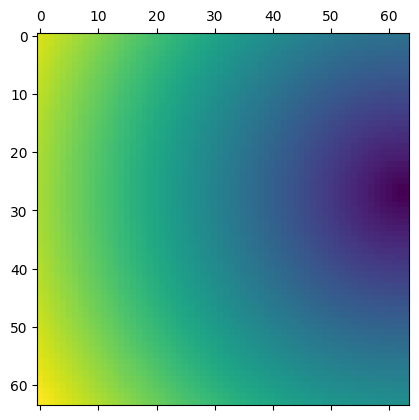

In [38]:
plt.matshow(spatial_maps[100])

In [168]:
def get_cnn_dis(sample_coords, ref_coords_x, ref_coords_y):
    dis_list = []
    for i in range(sample_coords.shape[0]):
        sample_coords_x = sample_coords[i][0]
        sample_coords_y = sample_coords[i][1]
        dis = np.sqrt(np.square(ref_coords_x - sample_coords_x) + np.square(ref_coords_y - sample_coords_y))
        dis_list.append(dis)
    return np.array(dis_list)

In [172]:
dis_scaler = StandardScaler()
dis_train_scaled = dis_scaler.fit_transform(
    get_cnn_dis(SimulatedData.xy, SimulatedData.xy[:, 0], SimulatedData.xy[:, 1]))

In [180]:
def reshape_dis(dis_to_reshape):
    dis_reshaped = []
    for i in range(dis_to_reshape.shape[0]):
        dis_ = np.expand_dims(dis_to_reshape[i].reshape(64, 64), axis=2)
        dis_reshaped.append(dis_)
    return np.array(dis_reshaped)

In [184]:
dis_reshaped = reshape_dis(dis_train_scaled)
dis_reshaped.shape

(4096, 64, 64, 1)

In [186]:
SimulatedData.xy[100]

array([ 37.48412698, 115.5714286 ])

In [46]:
import torch

In [50]:
m = SimpleCNN(nbetas=3)

In [67]:
import torch.nn as nn
import torch.optim as optim
device = torch.device('mps')

In [69]:
# inputs_x = torch.from_numpy(SimulatedData.gt[['x1', 'x2']].values).float().to(device)
# inputs_x.shape

torch.Size([4096, 2])

In [102]:
from spaceoracle.models.pixel_attention import NicheAttentionNetwork

In [101]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
inputs_x = scaler.fit_transform(SimulatedData.gt[['x1', 'x2']].values)
inputs_x = torch.from_numpy(inputs_x).float().to(device)

In [134]:
dist_scaler = StandardScaler()

In [159]:
from tqdm import tqdm
from pysal.model.spreg import OLS


In [152]:
spatial_maps_scaled = np.array([dist_scaler.fit_transform(s.reshape(-1, 1)).reshape(64, 64) for s in tqdm(spatial_maps)])

100%|██████████| 4096/4096 [00:00<00:00, 9903.72it/s]


In [160]:
ols = OLS(SimulatedData.y, inputs_x.detach().cpu().numpy(), name_y = 'y', name_x = ['x1', 'x2'])

In [164]:
ols.betas = torch.from_numpy(ols.betas).float().to(device)

In [218]:
m = SimpleCNN(nbetas=3).to(device)
# m = NicheAttentionNetwork(n_regulators=2, in_channels=1, spatial_dim=64).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(m.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
batch_size = 4096

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(0, len(spatial_maps), batch_size):
        # Get batch
        batch = torch.from_numpy(dis_reshaped[i:i+batch_size]).permute(0, 3, 1, 2).float().to(device)
        targets = torch.from_numpy(SimulatedData.y[i:i+batch_size]).float().to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        betas = m(batch).squeeze()
        # betas = m(batch, torch.zeros(len(batch), dtype=torch.long, device=device)).squeeze()


        y_pred = betas[:, 0]*ols.betas[0] + ols.betas[1]*betas[:, 1]*inputs_x[i:i+batch_size, 0] + ols.betas[2]*betas[:, 2]*inputs_x[i:i+batch_size, 1]

        # Compute loss
        loss = criterion(y_pred, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss/len(spatial_maps):.4g}')

Epoch [0/1000], Loss: 0.003642
Epoch [100/1000], Loss: 0.0002067
Epoch [200/1000], Loss: 0.0001741
Epoch [300/1000], Loss: 8.97e-05
Epoch [400/1000], Loss: 7.764e-05
Epoch [500/1000], Loss: 7.339e-05
Epoch [600/1000], Loss: 7.42e-05
Epoch [700/1000], Loss: 7.104e-05
Epoch [800/1000], Loss: 7.167e-05
Epoch [900/1000], Loss: 6.314e-05


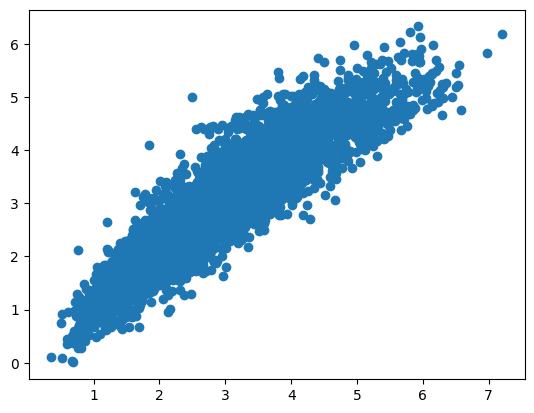

In [219]:
plt.scatter(y_pred.detach().cpu().numpy(), targets.detach().cpu().numpy())

In [220]:
# with torch.no_grad():       
#     betas = m.forward(
#         torch.from_numpy(spatial_maps).unsqueeze(1).float().to(device), 
#         torch.zeros(len(spatial_maps), dtype=torch.long, device=device)
#     )
# betas.shape

with torch.no_grad():       
    betas = m.forward(
        torch.from_numpy(dis_reshaped).permute(0, 3, 1, 2).float().to(device)
    )
betas.shape


torch.Size([4096, 3])

In [221]:
betas

tensor([[0.9472, 0.8822, 0.8778],
        [0.9819, 0.9066, 0.7339],
        [0.8799, 0.9306, 0.9271],
        ...,
        [1.1594, 1.0609, 0.9404],
        [0.8010, 0.7382, 0.7220],
        [0.7898, 0.6226, 0.5669]], device='mps:0')

In [224]:
ols.betas[1]*betas[:, 1]

tensor([0.5896, 0.6059, 0.6220,  ..., 0.7091, 0.4934, 0.4161], device='mps:0')

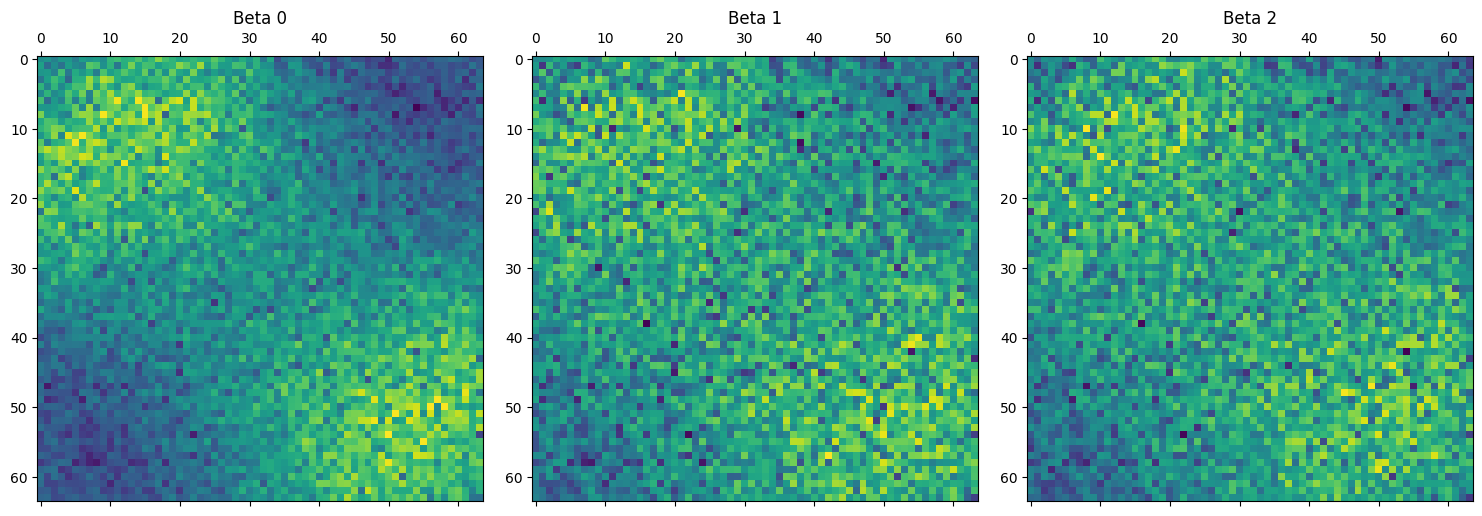

In [226]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].matshow((ols.betas[0]*betas[:, 0]).reshape(64, 64).detach().cpu().numpy())
axs[0].set_title('Beta 0')
axs[1].matshow((ols.betas[1]*betas[:, 1]).reshape(64, 64).detach().cpu().numpy())
axs[1].set_title('Beta 1')
axs[2].matshow((ols.betas[2]*betas[:, 2]).reshape(64, 64).detach().cpu().numpy())
axs[2].set_title('Beta 2')
plt.tight_layout()
plt.show()

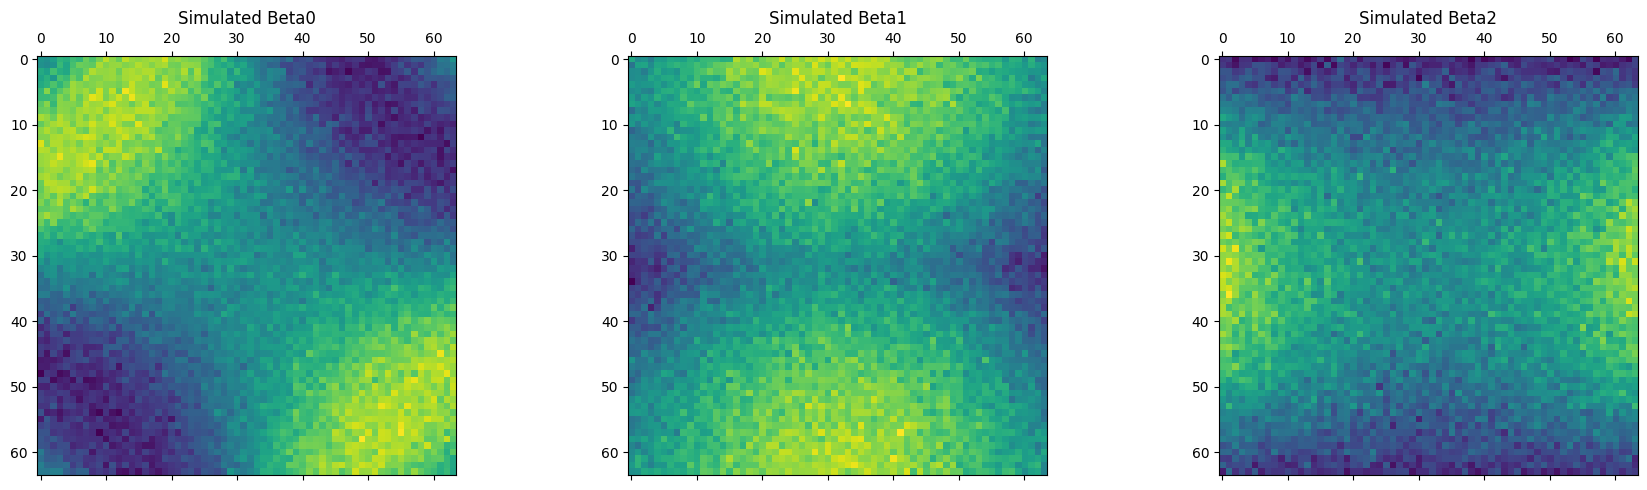

In [132]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.matshow(SimulatedData.beta0.reshape(64, 64))
ax1.set_title('Simulated Beta0')
ax2.matshow(SimulatedData.beta1.reshape(64, 64))
ax2.set_title('Simulated Beta1')
ax3.matshow(SimulatedData.beta2.reshape(64, 64))
ax3.set_title('Simulated Beta2')
plt.tight_layout()
plt.show()

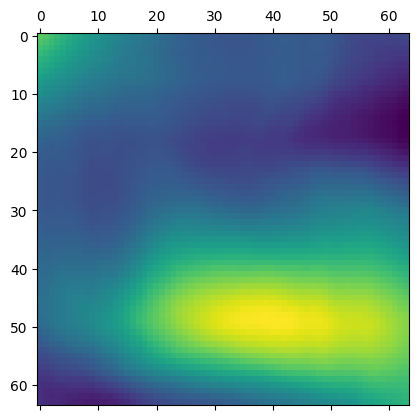

In [125]:
plt.matshow(betas[:, 2].reshape(64, 64).detach().cpu().numpy())

In [3]:
spatial_dim = 64

def get_beta(row, col, row_ext, col_ext):
    
    beta0 = 1 + np.sin((1 / row_ext / col_ext * 4) * np.pi * (row_ext / 2 - row) * (col_ext / 2 - col)) + np.random.normal() / 8
    beta1 = 1 + np.abs(np.cos((1 / row_ext) * np.pi * row)) + np.sin((1 / col_ext) * np.pi * col) + np.random.normal() / 7
    beta2 = 1 + (1 / (4 * (np.power(col_ext / 2, 2) * 0.5) * (np.power(row_ext / 2, 2) * 0.5))) * (np.square(col_ext / 2) + np.square(col_ext / 2 - col)) * (np.square(row_ext / 2) - np.square(row_ext / 2 - row)) + np.random.normal() / 6
    beta3 = 1 + np.cos((1 / row_ext / col_ext * 2) * np.pi * row * col) + np.random.normal() / 5
    beta4 = 1 + np.sin((1 / row_ext) * np.pi * row) * np.cos((1 / col_ext) * np.pi * col) + np.random.normal() / 4
    beta5 = 1 + np.exp(-((row - row_ext/2)**2 + (col - col_ext/2)**2) / (row_ext * col_ext / 10)) + np.random.normal() / 3

    return beta0, beta1, beta2, beta3, beta4, beta5


row_range = spatial_dim
col_range = spatial_dim

beta0 = []
beta1 = []
beta2 = []
beta3 = []
beta4 = []
beta5 = []

for row_i in range(row_range):
    beta0_ = []
    beta1_ = []
    beta2_ = []
    beta3_ = []
    beta4_ = []
    beta5_ = []
    for col_i in range(col_range):
        beta0_i, beta1_i, beta2_i, beta3_i, beta4_i, beta5_i = get_beta(row_i, col_i, row_range, col_range)
        beta0_.append(beta0_i)
        beta1_.append(beta1_i)
        beta2_.append(beta2_i)
        beta3_.append(beta3_i)
        beta4_.append(beta4_i)
        beta5_.append(beta5_i)
    beta0.append(beta5_)
    beta1.append(beta1_)
    beta2.append(beta2_)
    beta3.append(beta3_)
    beta4.append(beta4_)
    beta5.append(beta0_)

beta0 = np.array(beta0, dtype=np.float64)
beta1 = np.array(beta1, dtype=np.float64)
beta2 = np.array(beta2, dtype=np.float64)
beta3 = np.array(beta3, dtype=np.float64)
beta4 = np.array(beta4, dtype=np.float64)
beta5 = np.array(beta5, dtype=np.float64)

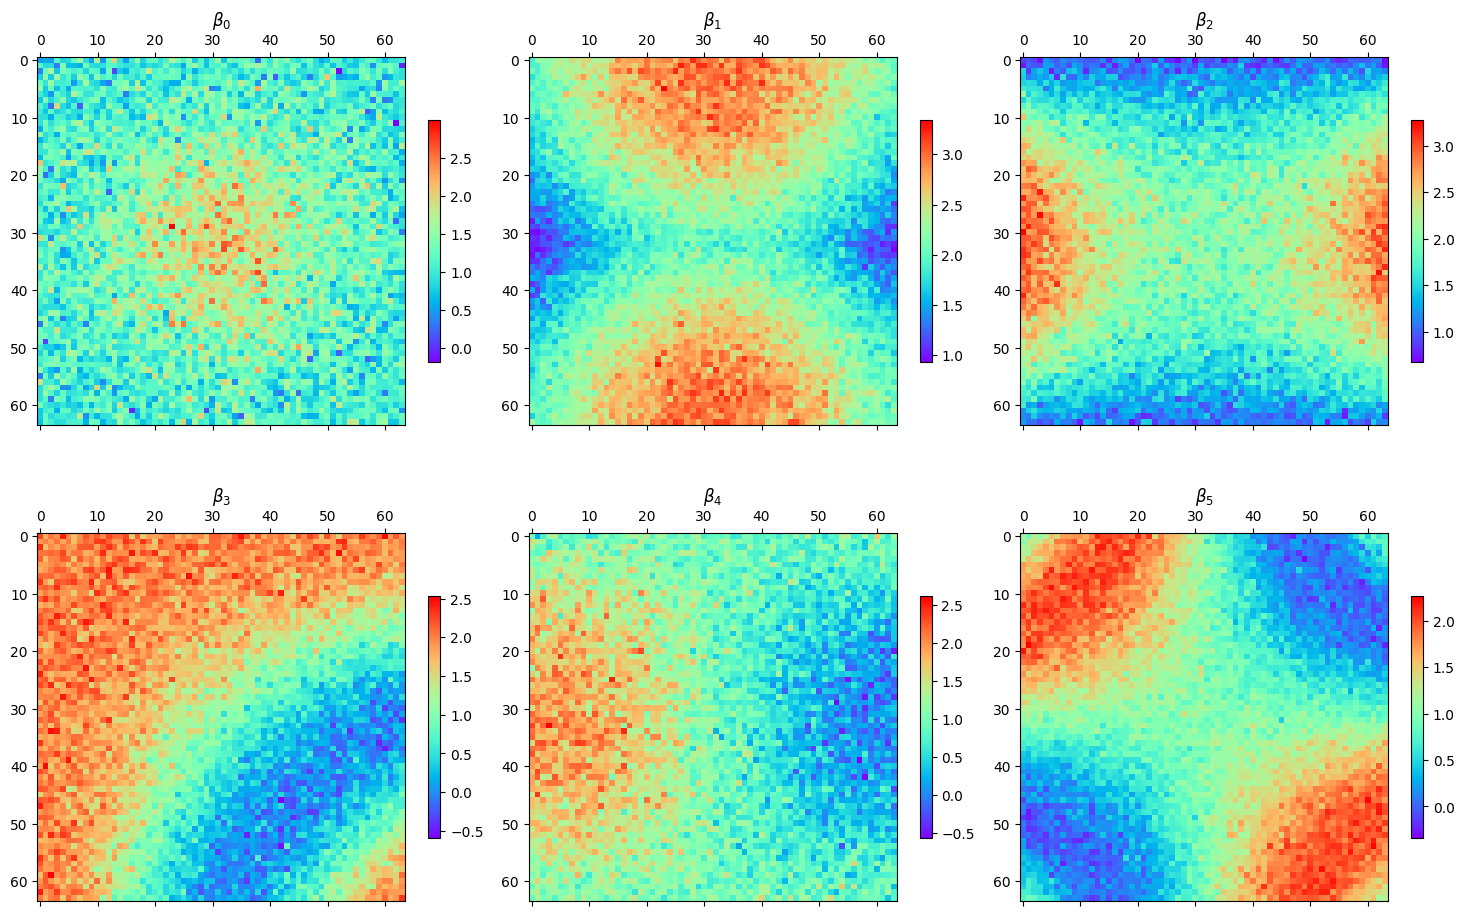

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

betas = [beta0, beta1, beta2, beta3, beta4, beta5]
titles = [r'$\beta_0$', r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\beta_4$', r'$\beta_5$']

for i, (beta, title) in enumerate(zip(betas, titles)):
    im = axs[i].matshow(beta, cmap='rainbow')
    axs[i].set_title(title)
    fig.colorbar(im, ax=axs[i], shrink=0.5)

plt.tight_layout()
plt.show()

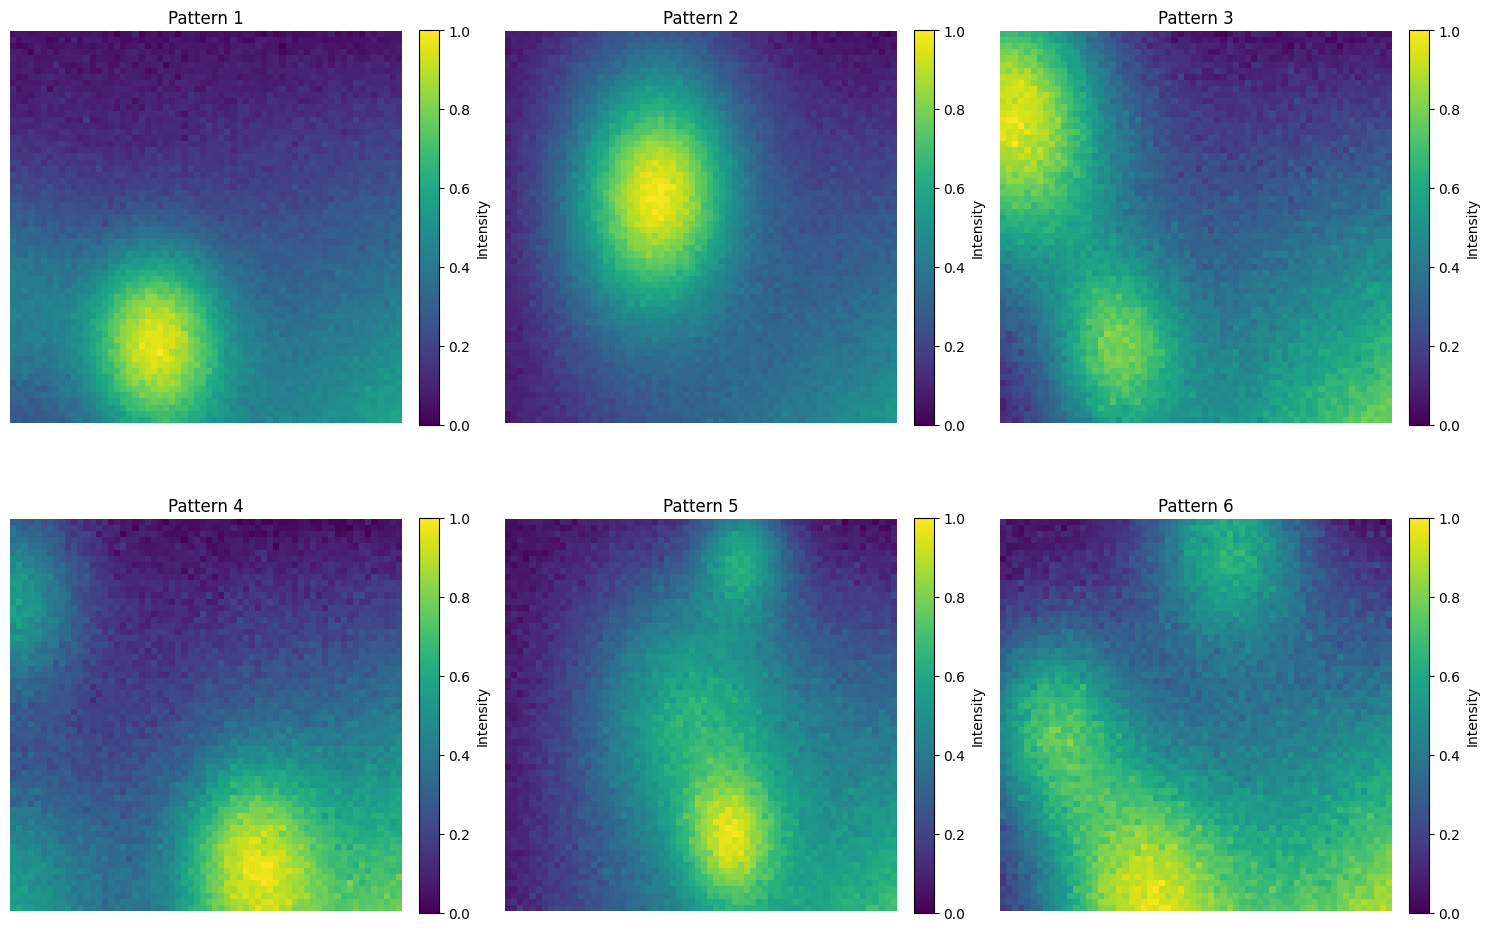

In [5]:
# Create 6 64x64 grids with spatial patterns

import numpy as np
import matplotlib.pyplot as plt

# Set the grid size
grid_size = 64

# Function to create a single spatial pattern
def create_spatial_pattern():
    x, y = np.meshgrid(np.linspace(0.1, 1.5, grid_size), np.linspace(0, 1, grid_size))
    grid = x * y

    for _ in range(3):
        center_x, center_y = np.random.rand(2)
        radius = np.random.uniform(0.1, 0.3)
        circle = np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * radius**2))
        grid += circle

    noise = np.random.normal(0, 0.05, (grid_size, grid_size))
    grid += noise

    return (grid - grid.min()) / (grid.max() - grid.min())

# Create 6 spatial patterns
tissue_grids = [create_spatial_pattern() for _ in range(6)]

# Visualize the results
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

for i, grid in enumerate(tissue_grids):
    im = axs[i].imshow(grid, cmap='viridis')
    axs[i].set_title(f'Pattern {i+1}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i], label='Intensity', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Store the results in variables for further use
tissue_grid1, tissue_grid2, tissue_grid3, tissue_grid4, tissue_grid5, tissue_grid6 = tissue_grids


In [6]:
np.array(tissue_grids).shape

(6, 64, 64)

In [8]:
import seaborn as sns
import anndata
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch
import pandas as pd
import pyro
import spaceoracle
from spaceoracle import SpaceOracle
from spaceoracle.tools.utils import clean_up_adata

In [9]:
indices = np.array(range(64*64))
y = indices // grid_size
x = indices % grid_size

In [10]:
# data_df = pd.DataFrame([i.flatten() for i in tissue_grids], 
#     columns=['sq{}'.format(i) for i in range(64*64)],
#     index=['var{}'.format(i) for i in ['A', 'B', 'C', 'D', 'E', 'F']]).T
# target_y = beta1*tissue_grids[1] + beta2*tissue_grids[2] + beta3*tissue_grids[3]*tissue_grids[4] + beta0
# data_df['target_y'] = target_y.flatten()


data_df = pd.DataFrame([np.random.normal(1, 0.01, (64, 64)).flatten() for i in tissue_grids], 
    columns=['sq{}'.format(i) for i in range(64*64)],
    index=['var{}'.format(i) for i in ['A', 'B', 'C', 'D', 'E', 'F']]).T
data_df['target_y'] = -1

,id,row,col,latitude,longitude,beta0,beta1,beta2,x1,x2,y,proj_x,proj_y
0,0,0,0,37.5,115.000000,1.058540,2.293887,1.056346,0.391720,0.566888,2.555933,12801741.44,4483017.170
1,1,0,1,37.5,115.015873,1.015311,1.972091,1.112009,0.479254,0.183225,2.164192,12803508.42,4483017.170
2,2,0,2,37.5,115.031746,1.165811,2.052675,0.740746,0.089783,0.308117,1.578343,12805275.39,4483017.170
3,3,0,3,37.5,115.047619,1.407816,1.831076,1.029166,0.255784,0.107331,1.986638,12807042.37,4483017.170
4,4,0,4,37.5,115.063492,1.348086,2.162551,1.043442,0.887085,0.555066,3.845633,12808809.35,4483017.170
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,63,59,36.5,115.936508,1.559996,2.286203,1.300961,0.542107,0.723439,3.740529,12905993.03,4344222.882
4092,4092,63,60,36.5,115.952381,1.492840,1.992985,1.210815,0.480357,0.827767,3.452458,12907760.00,4344222.882
4093,4093,63,61,36.5,115.968254,1.351371,2.208942,1.013919,0.808941,0.177852,3.318602,12909526.98,4344222.882
4094,4094,63,62,36.5,115.984127,1.481544,2.258388,1.226454,0.213466,0.334173,2.373481,12911293.96,4344222.882


In [290]:
# Normalize spatial_maps to between 0 and 1
spatial_maps = adata.obsm['spatial_maps']
normalized_maps = (spatial_maps - spatial_maps.min()) / (spatial_maps.max() - spatial_maps.min())

In [298]:
inputs_x = torch.from_numpy(SimulatedData.gt[['x1', 'x2']].values).float().to(device)
batch_y = torch.from_numpy(SimulatedData.gt['y'].values).float().to(device)

In [311]:
from tkinter import N
import torch.nn as nn
from tqdm import tqdm

criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

beta_init = np.array([1, 1, 1])
model = SimpleCNN(beta_init).to(device)

model.train()
total_loss = 0
losses = []
epochs = 100
with tqdm(range(epochs)) as pbar:
    for e in range(epochs):
        
        optimizer.zero_grad()
        betas = model(
            torch.from_numpy(adata.obsm['spatial_maps']).to(device), 
            torch.from_numpy(adata.obs['rctd_cluster'].values).long().to(device)
        )

        y_pred = betas[:, 0]
            
        for w in range(model.dim-1):
            y_pred += betas[:, w+1]*inputs_x[:, w]


        loss = criterion(y_pred.squeeze(), batch_y.to(device).squeeze())
        losses.append(loss.item())
        # loss += 1e-3*((betas.mean(0) - torch.from_numpy(anchors).float().mean(0).to(device))**2).sum()
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.update()
        pbar.set_description(f'Loss: {np.mean(losses):.3f}')

Loss: 12.369:  68%|██████▊   | 68/100 [01:10<00:33,  1.04s/it]


KeyboardInterrupt: 

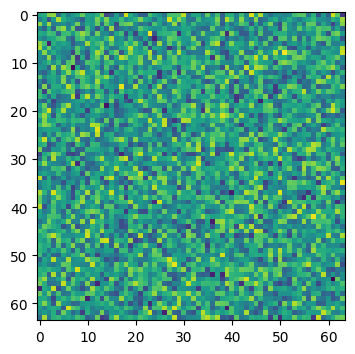

In [310]:
plt.imshow(betas[:, 0].detach().cpu().numpy().reshape(64, 64))
plt.show()

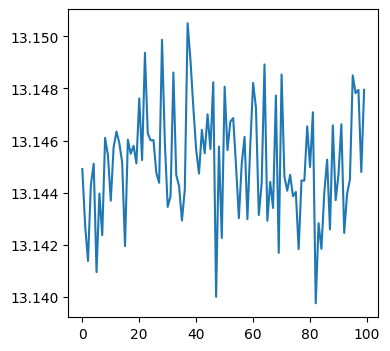

In [302]:
plt.plot(losses)

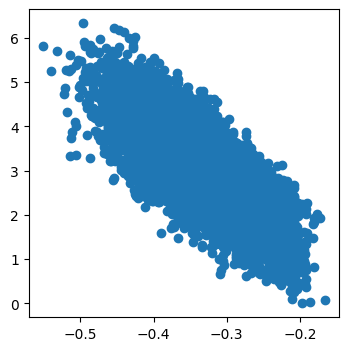

In [303]:
plt.scatter(y_pred.detach().cpu().numpy(), batch_y.detach().cpu().numpy())
plt.show()


In [108]:
data_df['varB'] = SimulatedData.gt.x1.values.flatten()
data_df['varC'] = SimulatedData.gt.x2.values.flatten()
data_df['target_y'] = SimulatedData.gt.y.values.flatten()

In [110]:
adata = anndata.AnnData(
    X=data_df, 
    obs=pd.DataFrame({'x': x, 'y': y}, index=data_df.index),
    obsm={'spatial': np.stack([x, y], axis=1)},
    layers={'imputed_count': data_df.values}
)

In [111]:
bdf = pd.DataFrame([i.flatten()*10 for i in betas], index=['beta{}'.format(i) for i in range(6)]).T

In [112]:
bdf['beta0'] = SimulatedData.gt.beta0
bdf['beta1'] = SimulatedData.gt.beta1
bdf['beta2'] = SimulatedData.gt.beta2


In [113]:
bdata = anndata.AnnData(
    X=bdf, 
    obs=pd.DataFrame({'x': x, 'y': y}, index=data_df.index),
    obsm={'spatial': np.stack([x, y], axis=1)}
)

In [114]:
adata.uns['received_ligands'] = ProbabilisticPixelModulators.received_ligands(
    adata, 
    [
        'varD', 
    ], 
    radius=8
)

100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


In [115]:
df_ligrec = pd.DataFrame(columns=['ligand', 'receptor', 'pathway', 'signaling', 'pairs'])
df_ligrec.loc[0] = ['varD', 'varE', 'pathway', 'signaling', 'varD$varE']

df_ligrec


,ligand,receptor,pathway,signaling,pairs
0,varD,varE,pathway,signaling,varD$varE


In [116]:
# adata.X[:, -1] = bdata.to_df()['beta1']*adata.to_df()['varB'] + \
# bdata.to_df()['beta2']*adata.to_df()['varC'] + \
# bdata.to_df()['beta3']*adata.uns['received_ligands']['varD']*adata.to_df()['varE'] + \
# bdata.to_df()['beta0']

# adata.X[:, -1] = bdata.to_df()['beta1']*adata.to_df()['varB'] + \
# bdata.to_df()['beta2']*adata.to_df()['varC'] + \
# bdata.to_df()['beta0']*1e-3



In [117]:
adata.layers['imputed_count'] = adata.X

In [118]:
adata.to_df()['varB']

sq0       0.391720
sq1       0.479254
sq2       0.089783
sq3       0.255784
sq4       0.887085
            ...   
sq4091    0.542107
sq4092    0.480357
sq4093    0.808941
sq4094    0.213466
sq4095    0.229529
Name: varB, Length: 4096, dtype: float64

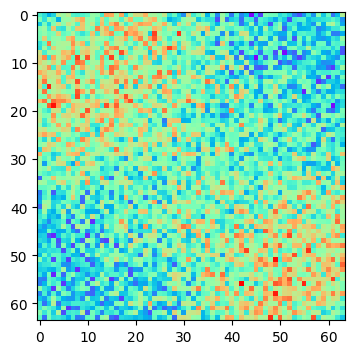

In [125]:
plt.imshow(adata.to_df()['target_y'].values.reshape(64, 64), cmap='rainbow')

In [126]:
adata.obs['rctd_cluster'] = 0

In [127]:

estimator = ProbabilisticPixelModulators(
    adata, target_gene='target_y', regulators=['varB', 'varC'],
    layer='imputed_count', df_ligrec=None)

In [128]:
estimator.regulators, estimator.ligands, estimator.receptors

(['varB', 'varC'], [], [])

In [129]:
adata.obs.drop(columns=['x', 'y'], inplace=True)

In [221]:
spatial_dim = 64

spaceoracle.SpaceOracle.imbue_adata_with_space(
    adata=adata, annot='rctd_cluster', 
    spatial_dim=spatial_dim, in_place=True, 
    method='fast'
)

🌍️ Generating spatial 64x64 maps...*


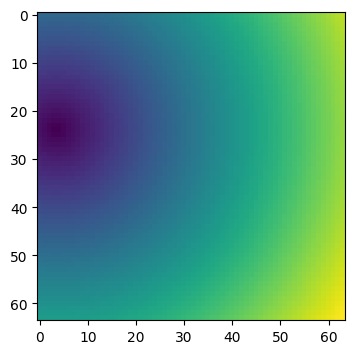

In [222]:
plt.imshow(adata.obsm['spatial_maps'][2500][0])

In [242]:
%%time
pyro.clear_param_store()

estimator.fit(
    annot='rctd_cluster', 
    max_epochs=100, 
    learning_rate=2e-4, 
    spatial_dim=spatial_dim,
    batch_size=512,
    alpha=0.9,
    cache=False,
    radius=8,
    parallel=False,
    rotate_maps=True
)

cluster 0: R2: 0.6206342584644794
VisionTransformer(in_channels=1, spatial_dim=64, n_patches=8, n_blocks=4, hidden_d=16, n_heads=2)
2 regulators + 0 ligand-receptor pairs


CPU times: user 36.2 s, sys: 2.96 s, total: 39.1 s
Wall time: 1min 7s


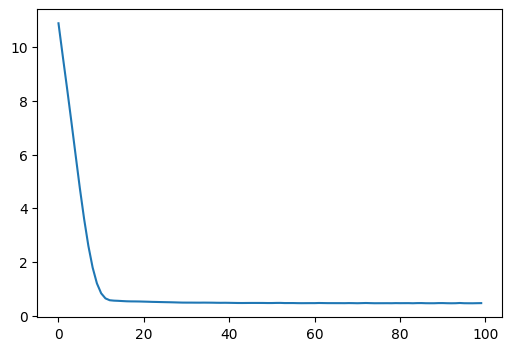

In [243]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(estimator.losses)

In [244]:
(
    bdata.to_df()['beta0'].mean(), 
    bdata.to_df()['beta1'].mean(), 
    bdata.to_df()['beta2'].mean(),
)

(0.999690001946045, 2.272532875711914, 1.8845122813825683)

In [245]:
estimator.betadata[['beta0', 'beta_varB', 'beta_varC']].mean(0)

beta0        0.945273
beta_varB    2.234652
beta_varC    1.923368
dtype: float64

In [246]:
y_true = adata.to_df()['target_y']

In [247]:
y_pred = estimator.betadata['beta_varB']*adata.to_df()['varB'] + \
estimator.betadata['beta_varC']*adata.to_df()['varC'] + \
estimator.betadata['beta0']*0.01

In [248]:
y_true.mean(), y_pred.mean()

(3.0974957342031253, 2.1053870632674747)

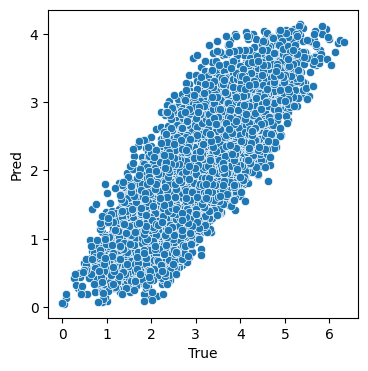

In [249]:
plt.rcParams['figure.figsize'] = (4, 4)
sns.scatterplot(x=y_true, y=y_pred)
plt.xlabel('True')
plt.ylabel('Pred')
plt.show()


In [250]:
# plt.matshow(estimator.betadata['target_y'].values.reshape(64, 64), cmap='rainbow')

In [251]:
estimator.betadata

,beta0,beta_varB,beta_varC,target_y,varB,varC,rctd_cluster,x,y
sq0,0.948264,2.238941,1.927152,2.555933,0.391720,0.566888,0,0,0
sq1,0.947965,2.238735,1.926462,2.164192,0.479254,0.183225,0,1,0
sq2,0.947583,2.238328,1.925474,1.578343,0.089783,0.308117,0,2,0
sq3,0.947152,2.237793,1.924299,1.986638,0.255784,0.107331,0,3,0
sq4,0.946688,2.237146,1.923003,3.845633,0.887085,0.555066,0,4,0
...,...,...,...,...,...,...,...,...,...
sq4091,0.948388,2.230376,1.927116,3.740529,0.542107,0.723439,0,59,63
sq4092,0.948713,2.230567,1.927186,3.452458,0.480357,0.827767,0,60,63
sq4093,0.949011,2.230683,1.927153,3.318602,0.808941,0.177852,0,61,63
sq4094,0.949218,2.230716,1.926906,2.373481,0.213466,0.334173,0,62,63


In [252]:
device = torch.device('mps')

In [253]:
adata.obsm['spatial_maps'].shape

(4096, 1, 64, 64)

In [254]:
torch.ones(len(adata)).to(device)

tensor([1., 1., 1.,  ..., 1., 1., 1.], device='mps:0')

In [255]:
P = estimator.model.forward(
    torch.from_numpy(adata.obsm['spatial_maps']).to(device), 
    torch.from_numpy(adata.obs['rctd_cluster'].values).long().to(device)
)

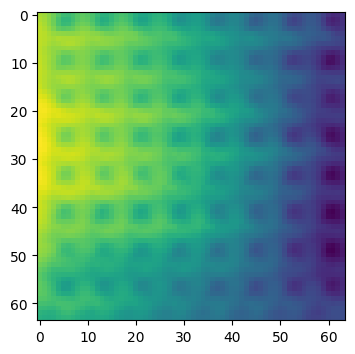

In [256]:
plt.imshow(P.detach().cpu().numpy()[:, 1].reshape(64, 64))

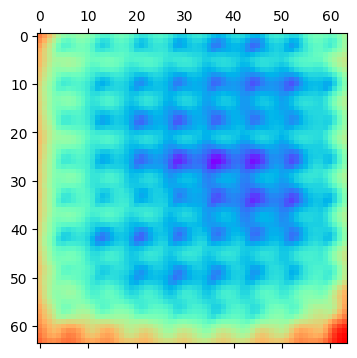

In [257]:
plt.matshow(estimator.betadata['beta0'].values.reshape(64, 64), cmap='rainbow')

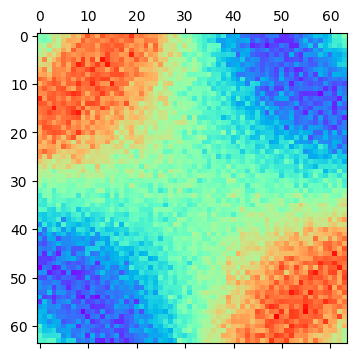

In [241]:
plt.matshow(bdata.to_df()['beta0'].values.reshape(64, 64), cmap='rainbow')

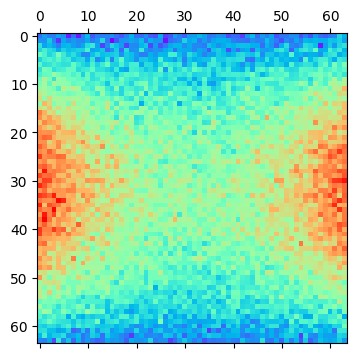

In [82]:
plt.matshow(bdata.to_df()['beta2'].values.reshape(64, 64), cmap='rainbow')

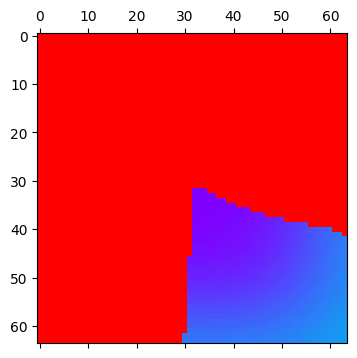

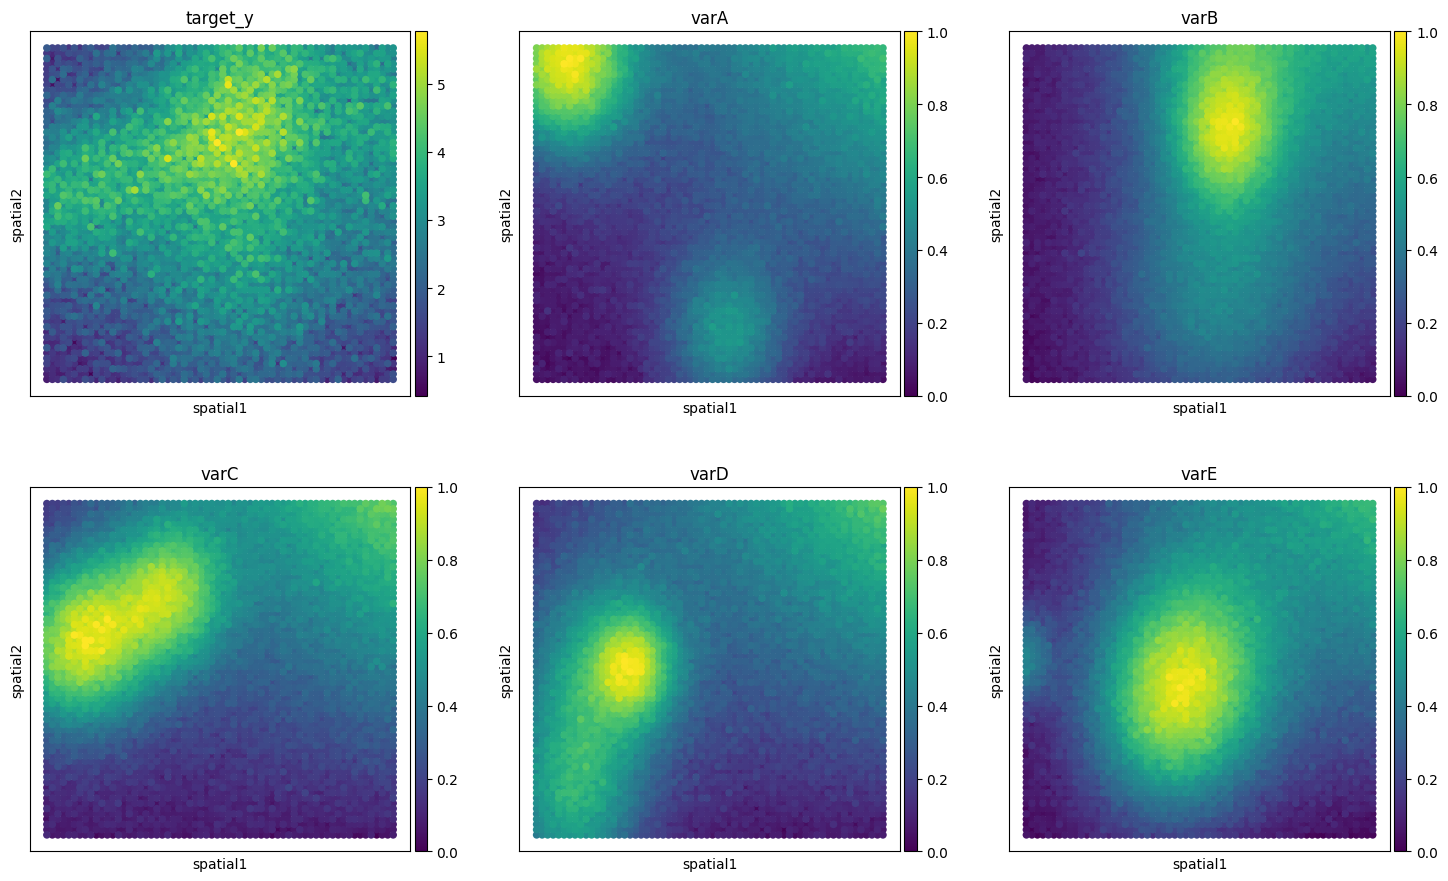

In [96]:
plt.rcParams['figure.figsize'] = (5, 5)
sc.pl.embedding(adata, ncols=3, color=['target_y', 'varA', 'varB', 'varC', 'varD', 'varE'], size=120, basis='spatial')

In [199]:
# plt.rcParams['figure.figsize'] = (5, 5)
# sc.pl.embedding(bdata, ncols=3, color=['beta0', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5'], size=120, basis='spatial')

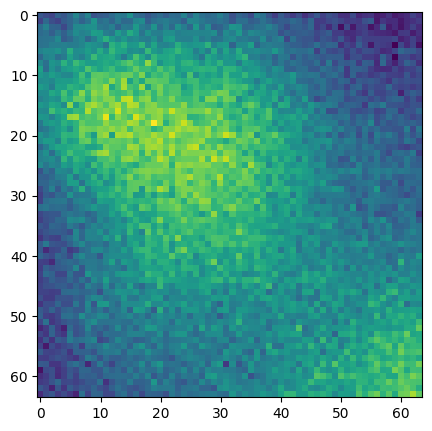

In [148]:
plt.imshow(beta1*tissue_grids[1] + beta2*tissue_grids[2] + beta3*tissue_grids[3]*tissue_grids[4] + beta0)

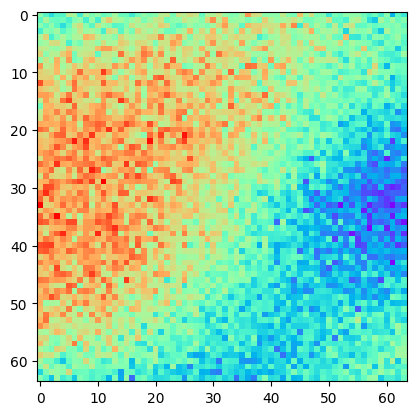

In [28]:
plt.imshow(beta1+beta2+beta3+beta4+beta5, cmap='rainbow')

In [16]:
beta1.min()

0.8714558320893173

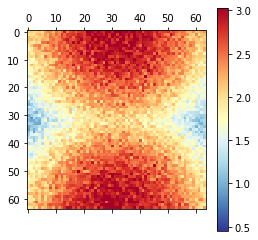

In [17]:
plt.matshow(beta1, cmap=plt.cm.get_cmap('RdYlBu_r'))
plt.colorbar()
plt.clim(3.5, 0.5)
plt.show()

In [19]:
beta2.max()

3.231915473879831

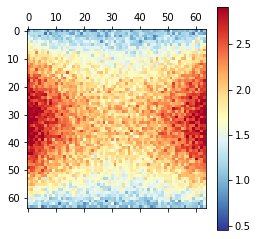

In [20]:
plt.matshow(beta2, cmap=plt.cm.get_cmap('RdYlBu_r'))
plt.colorbar()
plt.clim(3.5, 0.5)
plt.show()

array([[0.6298622 , 0.1888514 , 0.88764742, ..., 0.91294989, 0.9167964 ,
        0.07495219],
       [0.20273394, 0.81752677, 0.2459192 , ..., 0.4914079 , 0.02345285,
        0.94334225],
       [0.72367423, 0.66182914, 0.3829384 , ..., 0.99866747, 0.21607585,
        0.97098648],
       ...,
       [0.72586205, 0.35903899, 0.47170037, ..., 0.10128818, 0.77321169,
        0.31801403],
       [0.39480648, 0.4220295 , 0.05926689, ..., 0.62822831, 0.55120865,
        0.14252916],
       [0.6260503 , 0.59569872, 0.78797676, ..., 0.79652626, 0.83642213,
        0.5784107 ]])

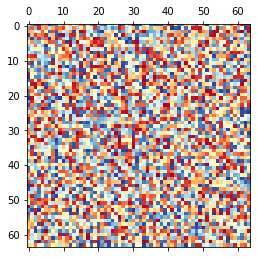

In [7]:
x1 = np.random.rand(row_range, col_range)
plt.matshow(x1, cmap=plt.cm.get_cmap('RdYlBu_r'))
x1

array([[0.01448175, 0.25556049, 0.90335507, ..., 0.52633235, 0.21445206,
        0.8215168 ],
       [0.53587246, 0.73524317, 0.22665125, ..., 0.61436169, 0.59317232,
        0.20511496],
       [0.4047111 , 0.26213229, 0.49563432, ..., 0.24952254, 0.09377595,
        0.19118113],
       ...,
       [0.52173117, 0.08311543, 0.61741558, ..., 0.39363271, 0.97363518,
        0.02998643],
       [0.3613384 , 0.32852327, 0.10946424, ..., 0.25973349, 0.99012003,
        0.37177739],
       [0.73681938, 0.37409986, 0.40752272, ..., 0.63979022, 0.57705637,
        0.00552546]])

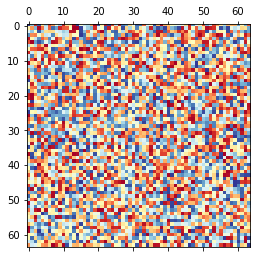

In [8]:
x2 = np.random.rand(row_range, col_range)
plt.matshow(x2, cmap=plt.cm.get_cmap('RdYlBu_r'))
x2

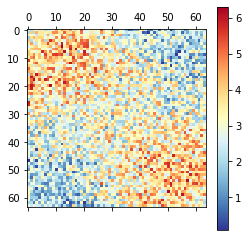

In [9]:
y = beta0 + beta1 * x1 + beta2 * x2
plt.matshow(y, cmap=plt.cm.get_cmap('RdYlBu_r'))
plt.colorbar()
plt.show()

In [10]:
y

array([[2.55593263, 2.16419152, 1.57834272, ..., 0.96092955, 1.69038282,
        3.80192168],
       [3.13644971, 2.19611435, 3.35204769, ..., 2.72538799, 2.3162638 ,
        1.24052778],
       [1.83967857, 3.08110816, 1.96346587, ..., 3.76525234, 2.65827805,
        1.44123872],
       ...,
       [2.44327136, 3.18542823, 2.69246979, ..., 2.04373097, 3.03460354,
        2.24484519],
       [3.28891066, 2.28728078, 3.0449645 , ..., 3.76433796, 3.34063267,
        2.77562386],
       [2.75659105, 0.9255775 , 3.0611252 , ..., 3.31860172, 2.3734813 ,
        1.83191203]])

In [2]:
import pandas as pd

In [12]:
simulate_data = []
for row in range(row_range):
    for col in range(col_range):
        longitude = 115.0+(116.0-115.0)/(col_range-1)*col
        latitude = 37.5-(37.5-36.5)/(row_range-1)*row
        simulate_data.append((row, col, latitude, longitude, beta0[row][col], beta1[row][col], beta2[row][col], x1[row][col], x2[row][col], y[row][col]))
simulate_data

[(0,
  0,
  37.5,
  115.0,
  1.0585399821688355,
  2.2938871849857554,
  1.0563457710376742,
  0.3917204016658221,
  0.5668884713932564,
  2.5559326310538157),
 (0,
  1,
  37.5,
  115.01587301587301,
  1.0153112144939709,
  1.9720906253494448,
  1.1120092877815968,
  0.4792537855466603,
  0.18322545390940004,
  2.164191518639025),
 (0,
  2,
  37.5,
  115.03174603174604,
  1.1658107267258153,
  2.052674750599127,
  0.7407461246130254,
  0.0897832755336968,
  0.30811653695966046,
  1.5783427201219735),
 (0,
  3,
  37.5,
  115.04761904761905,
  1.407815737385432,
  1.8310755207160279,
  1.0291664429147875,
  0.2557842516504273,
  0.10733143018243085,
  1.986637925381007),
 (0,
  4,
  37.5,
  115.06349206349206,
  1.3480858363293309,
  2.162551429050718,
  1.043441960539794,
  0.8870852327749784,
  0.555066246839882,
  3.845632686988721),
 (0,
  5,
  37.5,
  115.07936507936508,
  1.5019148869728802,
  2.1383493406930723,
  0.7612570925687173,
  0.9480018412475273,
  0.006931024466459101,
 

In [13]:
simulate_data_df = pd.DataFrame(data=simulate_data, columns=['row', 'col', 'latitude', 'longitude', 'beta0', 'beta1', 'beta2', 'x1', 'x2', 'y'])

In [14]:
simulate_data_df

,row,col,latitude,longitude,beta0,beta1,beta2,x1,x2,y
0,0,0,37.5,115.000000,1.058540,2.293887,1.056346,0.391720,0.566888,2.555933
1,0,1,37.5,115.015873,1.015311,1.972091,1.112009,0.479254,0.183225,2.164192
2,0,2,37.5,115.031746,1.165811,2.052675,0.740746,0.089783,0.308117,1.578343
3,0,3,37.5,115.047619,1.407816,1.831076,1.029166,0.255784,0.107331,1.986638
4,0,4,37.5,115.063492,1.348086,2.162551,1.043442,0.887085,0.555066,3.845633
...,...,...,...,...,...,...,...,...,...,...
4091,63,59,36.5,115.936508,1.559996,2.286203,1.300961,0.542107,0.723439,3.740529
4092,63,60,36.5,115.952381,1.492840,1.992985,1.210815,0.480357,0.827767,3.452458
4093,63,61,36.5,115.968254,1.351371,2.208942,1.013919,0.808941,0.177852,3.318602
4094,63,62,36.5,115.984127,1.481544,2.258388,1.226454,0.213466,0.334173,2.373481


In [2]:
import time

In [16]:
data_path = 'D:\\PythonProject\\Experiment\\gwr\\new\\data\\simulate_data_{}.csv'.format(time.strftime("%Y_%m_%d_%H_%M", time.localtime()))

In [17]:
simulate_data_df.to_csv(data_path, index=True, index_label='id', encoding='utf-8')

In [19]:
proj_data_path = 'D:\\PythonProject\\Experiment\\gwr\\new\\data\\simulate_data_2021_11_19_16_01_proj.csv'

In [28]:
proj_data = pd.read_csv(proj_data_path, index_col='id')

In [29]:
proj_data.head()

,row,col,latitude,longitude,beta0,beta1,beta2,x1,x2,y,proj_x,proj_y
id,,,,,,,,,,,,
0,0,0,37.5,115.000000,1.058540,2.293887,1.056346,0.391720,0.566888,2.555933,12801741.44,4483017.17
1,0,1,37.5,115.015873,1.015311,1.972091,1.112009,0.479254,0.183225,2.164192,12803508.42,4483017.17
2,0,2,37.5,115.031746,1.165811,2.052675,0.740746,0.089783,0.308117,1.578343,12805275.39,4483017.17
3,0,3,37.5,115.047619,1.407816,1.831076,1.029166,0.255784,0.107331,1.986638,12807042.37,4483017.17
4,0,4,37.5,115.063492,1.348086,2.162551,1.043442,0.887085,0.555066,3.845633,12808809.35,4483017.17


In [44]:
proj_data_sample_1 = proj_data.loc[proj_data['row']<=31].loc[proj_data['col']<=31].sample(frac=0.5)
len(proj_data_sample_1)

512

In [48]:
proj_data_sample_2 = proj_data.loc[proj_data['row']<=31].loc[proj_data['col']>31].sample(frac=0.2)
len(proj_data_sample_2)

205

In [49]:
proj_data_sample_3 = proj_data.loc[proj_data['row']>31].loc[proj_data['col']<=31].sample(frac=0.05)
len(proj_data_sample_3)

51

In [50]:
proj_data_sample_4 = proj_data.loc[proj_data['row']>31].loc[proj_data['col']>31].sample(frac=0.01)
len(proj_data_sample_4)

10

In [52]:
proj_data_sample = pd.concat([proj_data_sample_1, proj_data_sample_2, proj_data_sample_3, proj_data_sample_4])

In [57]:
proj_data_sample

,row,col,latitude,longitude,beta0,beta1,beta2,x1,x2,y,proj_x,proj_y
id,,,,,,,,,,,,
1421,22,13,37.150794,115.206349,1.581176,2.208094,2.086538,0.949576,0.736664,5.215006,12824712.13,4434339.598
405,6,21,37.404762,115.333333,1.748201,2.585447,1.147346,0.693686,0.014869,3.558749,12838847.94,4469718.814
1820,28,28,37.055556,115.444444,1.169864,2.196012,1.990522,0.888582,0.206250,3.531744,12851216.77,4421103.316
387,6,3,37.404762,115.047619,1.849429,2.065597,1.658342,0.095648,0.748153,3.287692,12807042.37,4469718.814
335,5,15,37.420635,115.238095,1.925009,2.376229,1.274395,0.263940,0.080110,2.654283,12828246.08,4471934.021
...,...,...,...,...,...,...,...,...,...,...,...,...
3751,58,39,36.579365,115.619048,1.456098,2.875959,1.422675,0.931296,0.361427,4.648659,12870653.51,4355171.503
2361,36,57,36.928571,115.904762,1.086124,1.774858,2.673416,0.559680,0.490727,3.391393,12902459.08,4403480.972
2855,44,39,36.801587,115.619048,1.392121,2.298960,1.727041,0.618136,0.274573,3.287391,12870653.51,4385888.210


In [53]:
proj_data_sample.to_csv('D:\\PythonProject\\Experiment\\gwr\\new\data\\simulate_data_2021_11_19_16_01_proj_sample.csv')

In [54]:
proj_data_sample.index

Int64Index([1421,  405, 1820,  387,  335, 1158, 1422,  389, 1224, 1172,
            ...
            3496, 2676, 2850, 4020, 3891, 3751, 2361, 2855, 3554, 3044],
           dtype='int64', name='id', length=778)

In [55]:
proj_data_no_sample = proj_data.drop(proj_data_sample.index)

In [58]:
proj_data_no_sample.to_csv('D:\\PythonProject\\Experiment\\gwr\\new\data\\simulate_data_2021_11_19_16_01_proj_no_sample.csv')

In [3]:
simulate_data_grid_32 = []
for row in range(32):
    for col in range(32):
        longitude = (115.0+1.0/63.0/2.0)+(116.0-115.0-1.0/63.0)/(32-1)*col
        latitude = (37.5-1.0/63.0/2.0)-(37.5-36.5-1.0/63.0)/(32-1)*row
        simulate_data_grid_32.append((row, col, latitude, longitude))
simulate_data_grid_32

[(0, 0, 37.492063492063494, 115.0079365079365),
 (0, 1, 37.492063492063494, 115.03968253968254),
 (0, 2, 37.492063492063494, 115.07142857142857),
 (0, 3, 37.492063492063494, 115.10317460317461),
 (0, 4, 37.492063492063494, 115.13492063492063),
 (0, 5, 37.492063492063494, 115.16666666666667),
 (0, 6, 37.492063492063494, 115.1984126984127),
 (0, 7, 37.492063492063494, 115.23015873015873),
 (0, 8, 37.492063492063494, 115.26190476190476),
 (0, 9, 37.492063492063494, 115.2936507936508),
 (0, 10, 37.492063492063494, 115.32539682539682),
 (0, 11, 37.492063492063494, 115.35714285714286),
 (0, 12, 37.492063492063494, 115.38888888888889),
 (0, 13, 37.492063492063494, 115.42063492063492),
 (0, 14, 37.492063492063494, 115.45238095238095),
 (0, 15, 37.492063492063494, 115.48412698412699),
 (0, 16, 37.492063492063494, 115.51587301587301),
 (0, 17, 37.492063492063494, 115.54761904761905),
 (0, 18, 37.492063492063494, 115.57936507936508),
 (0, 19, 37.492063492063494, 115.61111111111111),
 (0, 20, 37.4

In [7]:
simulate_data_grid_32_df = pd.DataFrame(data=simulate_data_grid_32, columns=['row', 'col', 'latitude', 'longitude'])

In [8]:
simulate_data_grid_32_df.to_csv('D:\\PythonProject\\Experiment\\gwr\\new\data\\simulate_data_grid_32_df.csv')